In [0]:
from keras.datasets import cifar10
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

Using TensorFlow backend.


The scope of this notebook is to maximize the accuracy of the test set for this image classification task. 

Image classification task is one of the most famous topics for the last 5 years. VGGNet neural networks performed very well in the  ImageNet Large Scale Visual Recognition Challenge (https://arxiv.org/abs/1409.1556). 

As a consequence, we implemented 4 models using VGG block architecture: 

    1) 1 VGG block (batch_size=128 , number of batches = 50 )

    2) 3 VGG blocks (batch_size=128 , number of batches = 50 ) 

    3) 3 VGG blocks using batch normalization (batch_size=128 , number of batches = 50 )

    4) 3 VGG blocks using batch normalization (using the whole dataset)

From Part 2 we can conclude that the optimal optimizer is the Adam and that the model performs better using dropout. So, dropout is used in all architectures. Also, Adam optimizer is used for the training of the model. 



In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.utils import shuffle
import statistics


# Import Data 

In [0]:

# Shapes of training set
print("Training set images shape: {shape}".format(shape=data_train.shape))
print("Training set labels shape: {shape}".format(shape=label_train.shape))

# Shapes of test set
print("Test set images shape: {shape}".format(shape=data_test.shape))
print("Test set labels shape: {shape}".format(shape=label_test.shape))

data_train = data_train.astype(np.float32)
data_test = data_test.astype(np.float32)
# data preprocessing
data_train = data_train / 255.0
data_test = data_test / 255.0

Training set images shape: (50000, 32, 32, 3)
Training set labels shape: (50000, 1)
Test set images shape: (10000, 32, 32, 3)
Test set labels shape: (10000, 1)


# Model 1: 1 VGG block

In [0]:
def classification_cnn(data, training=False):
    with tf.variable_scope('classification_cnn', reuse=tf.AUTO_REUSE):
        inputs = data
        # block 1 
        conv1 = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
        conv2 = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        dropout1 = tf.layers.dropout(inputs=pool1, rate=0.2, training=training)

        # flatten inputs for dense layer
        p2_flat = tf.reshape(pool1, [-1, 16 * 16 * 32])  
        # dense layer
        h1 = tf.layers.dense(inputs=p2_flat, units=128, activation=tf.nn.relu)
        # output layer
        outputs = tf.layers.dense(inputs=h1, units=10, activation=None) # 

    return outputs

# Model 2: 3 VGG blocks 

In [0]:
def classification_cnn_vgg_3(data, training=False):
    with tf.variable_scope('classification_cnn', reuse=tf.AUTO_REUSE):
        inputs = data
        # block 1
        conv1 = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
        conv2 = tf.layers.conv2d(inputs=conv1, filters=32, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        dropout1 = tf.layers.dropout(inputs=pool1, rate=0.2, training=training)
        # block 2 
        conv3 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
        conv4 = tf.layers.conv2d(inputs=conv3, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)
        dropout2 = tf.layers.dropout(inputs=pool2, rate=0.2, training=training)
        # block 3 
        conv5 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
        conv6 = tf.layers.conv2d(inputs=conv5, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
        pool3 = tf.layers.max_pooling2d(inputs=conv6, pool_size=[2, 2], strides=2)
        dropout3 = tf.layers.dropout(inputs=pool3, rate=0.2, training=training)

        # flatten inputs for dense layer
        p2_flat = tf.reshape(dropout3, [-1, 4 * 4 * 128])  
        # dense layer
        h1 = tf.layers.dense(inputs=p2_flat, units=128, activation=tf.nn.relu)
        # output layer
        outputs = tf.layers.dense(inputs=h1, units=10, activation=None) # 

    return outputs

# Model 3: 3 VGG blocks using batch normalization 

Training an deep neural network can be a very time consuming procedure with high sensitivity to the random initialization of the weight and configurations of the algortihm. 

The distribution of the inputs in each layer of the network change after each batch when the weights are updated (internal covariance shift). The covariance shift cause a difficulty to the DNN to converge.

Batch Normalization technique can help to solve the above problem (https://arxiv.org/pdf/1502.03167.pdf - [Ioffe and Szegedy 2015]). This method draws its strength from making normalization a part of the model architecture and performing the normalization for each training mini-batch. Also, it significantly reduces the time needed for training.

After each convolutional layer we apply batch normalization and indeed the training time is significantly reduced.



In [0]:
def classification_cnn_vgg_3_batch_normalization(data, training=False):
    with tf.variable_scope('classification_cnn', reuse=tf.AUTO_REUSE):
        inputs = data
        # block 1  
        conv1 = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
        b_1 = tf.compat.v1.layers.batch_normalization(inputs = conv1)
        conv2 = tf.layers.conv2d(inputs=b_1, filters=32, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
        b_2 = tf.compat.v1.layers.batch_normalization(inputs = conv2)

        pool1 = tf.layers.max_pooling2d(inputs=b_2, pool_size=[2, 2], strides=2)
        dropout1 = tf.layers.dropout(inputs=pool1, rate=0.2, training=training)

        # block 2 
        conv3 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
        b_3 = tf.compat.v1.layers.batch_normalization(inputs = conv3)
        conv4 = tf.layers.conv2d(inputs=b_3, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
        b_4 = tf.compat.v1.layers.batch_normalization(inputs = conv4)

        pool2 = tf.layers.max_pooling2d(inputs=b_4, pool_size=[2, 2], strides=2)
        dropout2 = tf.layers.dropout(inputs=pool2, rate=0.2, training=training)

        # block 3 
        conv5 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
        b_5 = tf.compat.v1.layers.batch_normalization(inputs = conv5)
        conv6 = tf.layers.conv2d(inputs=b_5, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
        b_6 =  tf.compat.v1.layers.batch_normalization(inputs = conv6)

        pool3 = tf.layers.max_pooling2d(inputs=b_6, pool_size=[2, 2], strides=2)
        dropout3 = tf.layers.dropout(inputs=pool3, rate=0.2, training=training)

        # flatten inputs for dense layer
        p2_flat = tf.reshape(dropout3, [-1, 4 * 4 * 128])  
        # dense layer
        h1 = tf.layers.dense(inputs=p2_flat, units=128, activation=tf.nn.relu)
        # output layer
        outputs = tf.layers.dense(inputs=h1, units=10, activation=None) # 

    return outputs

# Function for Plotting Results

In [0]:
import seaborn as sns 
def graph_ (train_avg_acc_1, train_avg_loss_1, test_avg_acc_1, test_avg_loss_1 , test_top5_1 , train_top5_1 ):
  fig = plt.figure(figsize=(20,5))
  fig.subplots_adjust( wspace=0.3)
  ax1 = fig.add_subplot(1, 3 ,1)
  ax2 = fig.add_subplot(1, 3, 2)
  ax3 = fig.add_subplot(1, 3, 3)
  # Figure 1
  sns.lineplot(x=np.arange(len(train_avg_acc_1)), y=train_avg_acc_1,  ax=ax1)
  sns.lineplot(x=np.arange(len(test_avg_acc_1)), y=test_avg_acc_1,  ax=ax1)
  fig.legend(labels=['train','test'],loc='upper right', bbox_to_anchor=(0.13,0.81) )
  ax1.set_xlabel('Epochs',  fontsize=13)     
  ax1.set_ylabel('Accuracy',  fontsize=13)  
  ax1.grid(True)

  # Figure 2
  sns.lineplot(x=np.arange(len(train_avg_loss_1)), y=train_avg_loss_1,  ax=ax2)
  sns.lineplot(x=np.arange(len(test_avg_loss_1)), y=test_avg_loss_1,  ax=ax2)
  ax2.set_xlabel('Epochs',  fontsize=13)     
  ax2.set_ylabel('Loss',  fontsize=13)     
  ax2.grid(True)

  # Figure 3 
  sns.lineplot(x=np.arange(len(train_top5_1)), y=train_top5_1,  ax=ax3)
  sns.lineplot(x=np.arange(len(test_top5_1)), y=test_top5_1,  ax=ax3)
  ax3.set_xlabel('Epochs',  fontsize=13)     
  ax3.set_ylabel('Top 5 accuracy',  fontsize=13)     
  ax3.grid(True)


def graph_2 (train_avg_acc, train_avg_loss, valid_avg_acc, valid_avg_loss , valid_top5 , train_top5 , test_avg_acc, test_avg_loss , test_top5 ):
  fig = plt.figure(figsize=(20,5))
  fig.subplots_adjust( wspace=0.3)
  ax1 = fig.add_subplot(1, 3 ,1)
  ax2 = fig.add_subplot(1, 3, 2)
  ax3 = fig.add_subplot(1, 3, 3)
  # Figure 1
  sns.lineplot(x=np.arange(len(train_avg_acc)), y=train_avg_acc,  ax=ax1)
  sns.lineplot(x=np.arange(len(test_avg_acc)), y=test_avg_acc,  ax=ax1)
  sns.lineplot(x=np.arange(len(valid_avg_acc)), y=valid_avg_acc,  ax=ax1)
  fig.legend(labels=['train','test', 'validation'],loc='upper right', bbox_to_anchor=(0.13,0.81) )
  ax1.set_xlabel('Epochs',  fontsize=13)     
  ax1.set_ylabel('Accuracy',  fontsize=13)  
  ax1.grid(True)

  # Figure 2
  sns.lineplot(x=np.arange(len(train_avg_loss)), y=train_avg_loss,  ax=ax2)
  sns.lineplot(x=np.arange(len(test_avg_loss)), y=test_avg_loss,  ax=ax2)
  sns.lineplot(x=np.arange(len(valid_avg_loss)), y=valid_avg_loss,  ax=ax2)
  ax2.set_xlabel('Epochs',  fontsize=13)     
  ax2.set_ylabel('Loss',  fontsize=13)     
  ax2.grid(True)

  #Figure 3 
  sns.lineplot(x=np.arange(len(train_top5)), y=train_top5,  ax=ax3)
  sns.lineplot(x=np.arange(len(test_top5)), y=test_top5,  ax=ax3)
  sns.lineplot(x=np.arange(len(valid_top5)), y=valid_top5,  ax=ax3)
  ax3.set_xlabel('Epochs',  fontsize=13)     
  ax3.set_ylabel('Top 5 accuracy',  fontsize=13)     

  ax3.grid(True)


# Function for fitting Model 1

In [0]:
def fit_1(optimiser, batch_size,
        batch_count, epochs, xdim=32 ,
        data_train=data_train, label_train=label_train, data_test=data_test, label_test=label_test):

    graph1 = tf.Graph()
    with graph1.as_default():
      x = tf.placeholder(tf.float32, [None, xdim, xdim, 3], name='x')
      y = tf.placeholder(tf.int32, [None], name='y')
      training = tf.placeholder(tf.bool, shape=())
      outputs = classification_cnn(x, training)

      top1, top1_op = tf.metrics.accuracy(y, tf.argmax(outputs, axis=1))
      top5, top5_op = tf.metrics.mean(tf.nn.in_top_k(predictions=outputs, targets=y, k=5))

      loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=outputs))
      
      with tf.control_dependencies(tf.compat.v1.get_collection(tf.GraphKeys.UPDATE_OPS) + [top1_op, top5_op]   ):                                                            
        optimiser_ = optimiser.minimize(loss) 

    with tf.Session(graph=graph1) as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        train_avg_acc=[]
        train_top5=[]
        train_avg_loss=[] 
        test_avg_acc=[]
        test_avg_loss=[]
        test_top5=[]

        print ("Start")
        for e in range(epochs):
            avg_loss=0.
            avg_acc1=0. 
            avg_top_5=0.
            epoch_xs, epoch_ys = shuffle(data_train, label_train)
            for i in range(batch_count):
                # obtain the x, y data for the batch and optimize
                batch_xs = epoch_xs[i*batch_size:(i+1)*batch_size]
                batch_ys = epoch_ys[i*batch_size:(i+1)*batch_size]
                _, l, acc1, acc5 = sess.run([optimiser_, loss, top1, top5], feed_dict={x: batch_xs, y: batch_ys.flatten(), training: True})
                # update the avg_loss
                avg_loss += l 
                avg_acc1 += acc1 
                avg_top_5 += acc5         

            train_avg_acc.append( avg_acc1/batch_count)
            train_avg_loss.append(avg_loss/batch_count)
            train_top5.append(avg_top_5/batch_count)

            test1,test2,test3 = sess.run([top1, top5, loss], feed_dict={x: data_test, y: label_test.flatten(), training: False})
            test_avg_acc.append( test1)
            test_avg_loss.append(test3)
            test_top5.append(test2)
            print ("EPOCH = %.2f : top1_test = %.2f loss_test = %.2f top1_train = %.2f loss_train = %.2f" % (e, test1, test3, avg_acc1/batch_count, avg_loss/batch_count))

    return train_avg_acc, train_avg_loss, test_avg_acc, test_avg_loss , test_top5 , train_top5

# Function for fitting Model 2

In [0]:
def fit_2(optimiser, batch_size,
        batch_count, epochs, xdim=32 ,
        data_train=data_train, label_train=label_train, data_test=data_test, label_test=label_test):
    # reset the graph 
    graph1 = tf.Graph()
    with graph1.as_default():
      x = tf.placeholder(tf.float32, [None, xdim, xdim, 3], name='x')
      y = tf.placeholder(tf.int32, [None], name='y')
      training = tf.placeholder(tf.bool, shape=())
      outputs = classification_cnn_vgg_3(x, training)

      top1, top1_op = tf.metrics.accuracy(y, tf.argmax(outputs, axis=1))
      top5, top5_op = tf.metrics.mean(tf.nn.in_top_k(predictions=outputs, targets=y, k=5))

      loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=outputs))
      
      with tf.control_dependencies(tf.compat.v1.get_collection(tf.GraphKeys.UPDATE_OPS) + [top1_op, top5_op]   ):                                                            
        optimiser_ = optimiser.minimize(loss) 

    with tf.Session(graph=graph1) as sess:

        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        train_avg_acc=[]
        train_top5=[]
        train_avg_loss=[] 
        test_avg_acc=[]
        test_avg_loss=[]
        test_top5=[]

        print ("Start")
        for e in range(epochs):
            avg_loss=0.
            avg_acc1=0. 
            avg_top_5=0.
            epoch_xs, epoch_ys = shuffle(data_train, label_train)
            for i in range(batch_count):
                # obtain the x, y data for the batch and optimize
                batch_xs = epoch_xs[i*batch_size:(i+1)*batch_size]
                batch_ys = epoch_ys[i*batch_size:(i+1)*batch_size]
                _, l, acc1, acc5 = sess.run([optimiser_, loss, top1, top5], feed_dict={x: batch_xs, y: batch_ys.flatten(), training: True})
                # update the avg_loss
                avg_loss += l 
                avg_acc1 += acc1 
                avg_top_5 += acc5         

            train_avg_acc.append( avg_acc1/batch_count)
            train_avg_loss.append(avg_loss/batch_count)
            train_top5.append(avg_top_5/batch_count)

            test1,test2,test3 = sess.run([top1, top5, loss], feed_dict={x: data_test, y: label_test.flatten(), training: False})
            test_avg_acc.append( test1)
            test_avg_loss.append(test3)
            test_top5.append(test2)
            print ("EPOCH = %.2f : top1_test = %.2f loss_test = %.2f top1_train = %.2f loss_train = %.2f" % (e, test1, test3, avg_acc1/batch_count, avg_loss/batch_count))

    return train_avg_acc, train_avg_loss, test_avg_acc, test_avg_loss , test_top5 , train_top5

# Function for fitting Model 3





In [0]:
def fit_3(optimiser, batch_size,
        batch_count, epochs, xdim=32 ,
        data_train=data_train, label_train=label_train, data_test=data_test, label_test=label_test):
    # reset the graph 
    graph1 = tf.Graph()
    with graph1.as_default():
      x = tf.placeholder(tf.float32, [None, xdim, xdim, 3], name='x')
      y = tf.placeholder(tf.int32, [None], name='y')
      training = tf.placeholder(tf.bool, shape=())
      outputs = classification_cnn_vgg_3_batch_normalization(x, training)

      top1, top1_op = tf.metrics.accuracy(y, tf.argmax(outputs, axis=1))
      top5, top5_op = tf.metrics.mean(tf.nn.in_top_k(predictions=outputs, targets=y, k=5))

      loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=outputs))
      
      with tf.control_dependencies(tf.compat.v1.get_collection(tf.GraphKeys.UPDATE_OPS) + [top1_op, top5_op]   ):                                                            
        optimiser_ = optimiser.minimize(loss) 

    with tf.Session(graph=graph1) as sess:

        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        train_avg_acc=[]
        train_top5=[]
        train_avg_loss=[] 
        test_avg_acc=[]
        test_avg_loss=[]
        test_top5=[]

        print ("Start")
        for e in range(epochs):
            avg_loss=0.
            avg_acc1=0. 
            avg_top_5=0.
            epoch_xs, epoch_ys = shuffle(data_train, label_train)
            for i in range(batch_count):
                # obtain the x, y data for the batch and optimize
                batch_xs = epoch_xs[i*batch_size:(i+1)*batch_size]
                batch_ys = epoch_ys[i*batch_size:(i+1)*batch_size]
                _, l, acc1, acc5 = sess.run([optimiser_, loss, top1, top5], feed_dict={x: batch_xs, y: batch_ys.flatten(), training: True})
                # update the avg_loss
                avg_loss += l 
                avg_acc1 += acc1 
                avg_top_5 += acc5         

            train_avg_acc.append( avg_acc1/batch_count)
            train_avg_loss.append(avg_loss/batch_count)
            train_top5.append(avg_top_5/batch_count)

            test1,test2,test3 = sess.run([top1, top5, loss], feed_dict={x: data_test, y: label_test.flatten(), training: False})
            test_avg_acc.append( test1)
            test_avg_loss.append(test3)
            test_top5.append(test2)
            print ("EPOCH = %.2f : top1_test = %.2f loss_test = %.2f top1_train = %.2f loss_train = %.2f" % (e, test1, test3, avg_acc1/batch_count, avg_loss/batch_count))

    return train_avg_acc, train_avg_loss, test_avg_acc, test_avg_loss , test_top5 , train_top5

## Simulation 1: 1 VGG Block

In [0]:
Adamoptimiser = tf.train.AdamOptimizer(learning_rate=0.001)
train_avg_acc_1, train_avg_loss_1, test_avg_acc_1, test_avg_loss_1 , test_top5_1 , train_top5_1 = fit_1(Adamoptimiser, 128, 50, 100 )

Start
EPOCH = 0.00 : top1_test = 0.23 loss_test = 1.90 top1_train = 0.17 loss_train = 2.12
EPOCH = 1.00 : top1_test = 0.30 loss_test = 1.71 top1_train = 0.27 loss_train = 1.79
EPOCH = 2.00 : top1_test = 0.34 loss_test = 1.62 top1_train = 0.32 loss_train = 1.67
EPOCH = 3.00 : top1_test = 0.37 loss_test = 1.54 top1_train = 0.36 loss_train = 1.59
EPOCH = 4.00 : top1_test = 0.38 loss_test = 1.50 top1_train = 0.38 loss_train = 1.52
EPOCH = 5.00 : top1_test = 0.40 loss_test = 1.44 top1_train = 0.39 loss_train = 1.50
EPOCH = 6.00 : top1_test = 0.41 loss_test = 1.45 top1_train = 0.41 loss_train = 1.45
EPOCH = 7.00 : top1_test = 0.42 loss_test = 1.42 top1_train = 0.42 loss_train = 1.41
EPOCH = 8.00 : top1_test = 0.43 loss_test = 1.36 top1_train = 0.43 loss_train = 1.37
EPOCH = 9.00 : top1_test = 0.44 loss_test = 1.36 top1_train = 0.44 loss_train = 1.34
EPOCH = 10.00 : top1_test = 0.45 loss_test = 1.34 top1_train = 0.45 loss_train = 1.32
EPOCH = 11.00 : top1_test = 0.46 loss_test = 1.33 top1_tra

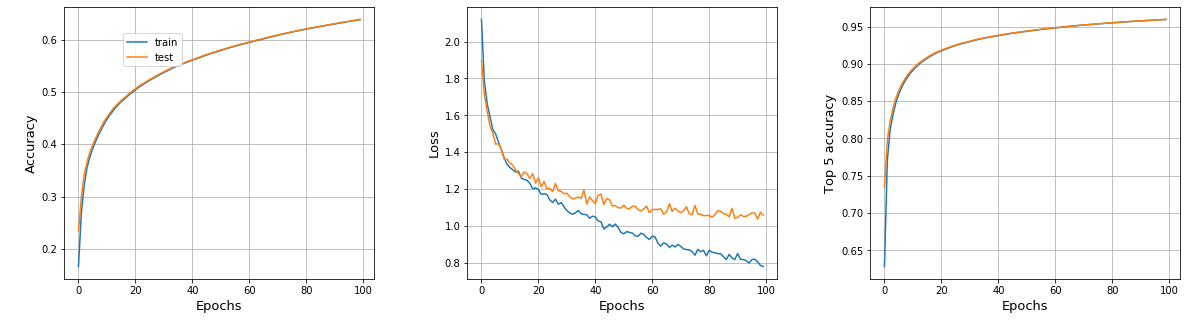

In [0]:
graph_(train_avg_acc_1, train_avg_loss_1, test_avg_acc_1, test_avg_loss_1 , test_top5_1 , train_top5_1 )  


In [0]:
print ("Accuracy of Training set : %.2f" % (train_avg_acc_1[-1]*100), "%")
print ("Accuracy of Test set : %.2f " % (test_avg_acc_1[-1]*100), "%")
print ("Top 5 Accuracy of Training set : %.2f"% (train_top5_1[-1]*100), "%")
print ("Top 5 Accuracy of Test set : %.2f" % (test_top5_1[-1]*100 ), "%")


Accuracy of Training set : 63.84 %
Accuracy of Test set : 63.88  %
Top 5 Accuracy of Training set : 95.96 %
Top 5 Accuracy of Test set : 95.97 %


As we can see above the model is valid since there is no indication for overfitting. The loss per epoch declined both for the training and test set. 
Also, the accuracy of the test and training set are quite close, the same goes for top 5 accuracy rate.


## Simulation 2: 3 VGG Blocks

In [0]:
Adamoptimiser = tf.train.AdamOptimizer(learning_rate=0.001)
train_avg_acc_1_vgg3, train_avg_loss_1_vgg3, test_avg_acc_1_vgg3, test_avg_loss_1_vgg3 , test_top5_1_vgg3 , train_top5_1_vgg3 = fit_2(Adamoptimiser, 128, 50, 100 )


Start
EPOCH = 0.00 : top1_test = 0.18 loss_test = 2.02 top1_train = 0.14 loss_train = 2.17
EPOCH = 1.00 : top1_test = 0.24 loss_test = 1.89 top1_train = 0.21 loss_train = 1.92
EPOCH = 2.00 : top1_test = 0.27 loss_test = 1.74 top1_train = 0.26 loss_train = 1.80
EPOCH = 3.00 : top1_test = 0.30 loss_test = 1.57 top1_train = 0.29 loss_train = 1.68
EPOCH = 4.00 : top1_test = 0.33 loss_test = 1.55 top1_train = 0.31 loss_train = 1.55
EPOCH = 5.00 : top1_test = 0.35 loss_test = 1.42 top1_train = 0.34 loss_train = 1.49
EPOCH = 6.00 : top1_test = 0.37 loss_test = 1.35 top1_train = 0.36 loss_train = 1.40
EPOCH = 7.00 : top1_test = 0.39 loss_test = 1.29 top1_train = 0.38 loss_train = 1.34
EPOCH = 8.00 : top1_test = 0.40 loss_test = 1.25 top1_train = 0.40 loss_train = 1.27
EPOCH = 9.00 : top1_test = 0.42 loss_test = 1.39 top1_train = 0.41 loss_train = 1.25
EPOCH = 10.00 : top1_test = 0.43 loss_test = 1.14 top1_train = 0.43 loss_train = 1.19
EPOCH = 11.00 : top1_test = 0.45 loss_test = 1.13 top1_tra

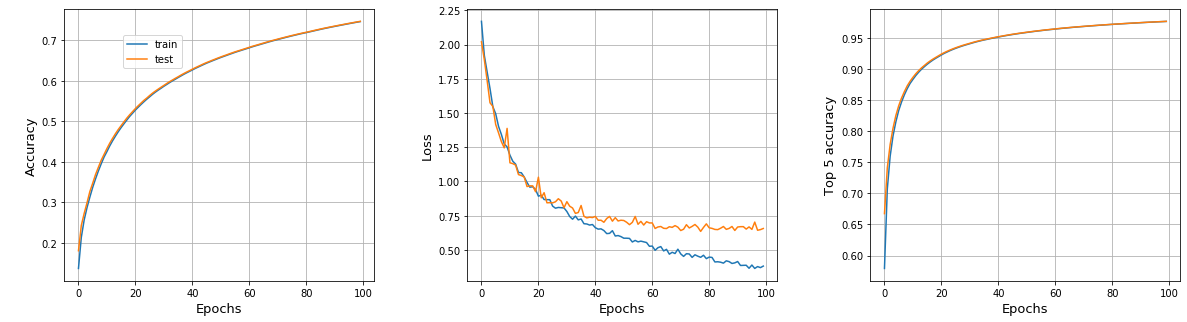

In [0]:
graph_(train_avg_acc_1_vgg3, train_avg_loss_1_vgg3, test_avg_acc_1_vgg3, test_avg_loss_1_vgg3 , test_top5_1_vgg3 , train_top5_1_vgg3)

In [0]:
print ("Accuracy of Training set : %.2f" % (train_avg_acc_1_vgg3[-1]*100), "%")
print ("Accuracy of Test set : %.2f " % (test_avg_acc_1_vgg3[-1]*100), "%")
print ("Top 5 Accuracy of Training set : %.2f"% (train_top5_1_vgg3[-1]*100), "%")
print ("Top 5 Accuracy of Test set : %.2f" % (test_top5_1_vgg3[-1]*100 ), "%")


Accuracy of Training set : 74.56 %
Accuracy of Test set : 74.62  %
Top 5 Accuracy of Training set : 97.59 %
Top 5 Accuracy of Test set : 97.60 %


Also, for this architecture there is no overfitting and again the model seem to be valid. 

Most significantly, for this deeper architecture the model performs much better since the accuracy of the test set is approximately 10% better than the previous model.


Also there is 2% improvement in the top5 accuracy rate.

## Simulation 3: 3 VGG Blocks using batch normalization 

In [0]:
Adamoptimiser = tf.train.AdamOptimizer(learning_rate=0.001)
train_avg_acc_vgg3_bn, train_avg_loss_vgg3_bn, test_avg_acc_vgg3_bn, test_avg_loss_vgg3_bn , test_top5_vgg3_bn , train_top5_vgg3_bn = fit_3(Adamoptimiser, 128, 50, 100 )

Start
EPOCH = 0.00 : top1_test = 0.17 loss_test = 1.94 top1_train = 0.13 loss_train = 2.20
EPOCH = 1.00 : top1_test = 0.24 loss_test = 1.75 top1_train = 0.21 loss_train = 1.85
EPOCH = 2.00 : top1_test = 0.29 loss_test = 1.57 top1_train = 0.27 loss_train = 1.68
EPOCH = 3.00 : top1_test = 0.32 loss_test = 1.47 top1_train = 0.30 loss_train = 1.58
EPOCH = 4.00 : top1_test = 0.35 loss_test = 1.41 top1_train = 0.33 loss_train = 1.48
EPOCH = 5.00 : top1_test = 0.37 loss_test = 1.34 top1_train = 0.36 loss_train = 1.42
EPOCH = 6.00 : top1_test = 0.39 loss_test = 1.33 top1_train = 0.38 loss_train = 1.34
EPOCH = 7.00 : top1_test = 0.41 loss_test = 1.23 top1_train = 0.40 loss_train = 1.26
EPOCH = 8.00 : top1_test = 0.42 loss_test = 1.16 top1_train = 0.42 loss_train = 1.22
EPOCH = 9.00 : top1_test = 0.44 loss_test = 1.14 top1_train = 0.43 loss_train = 1.16
EPOCH = 10.00 : top1_test = 0.46 loss_test = 1.06 top1_train = 0.45 loss_train = 1.10
EPOCH = 11.00 : top1_test = 0.47 loss_test = 0.99 top1_tra

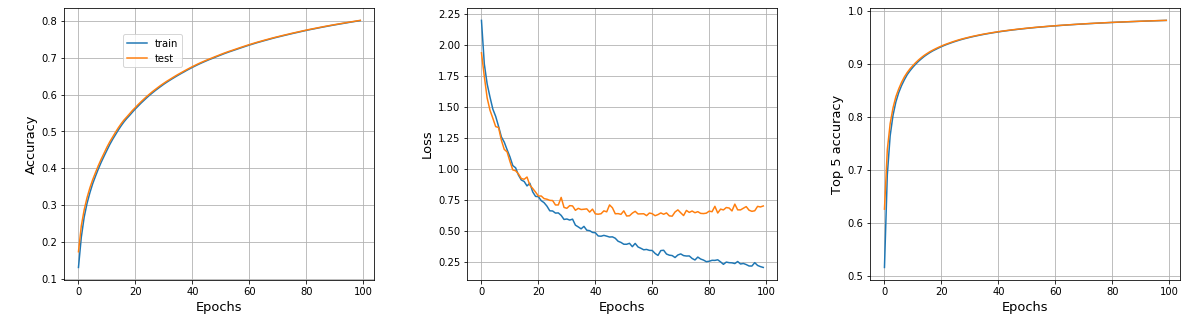

In [0]:
graph_(train_avg_acc_vgg3_bn, train_avg_loss_vgg3_bn, test_avg_acc_vgg3_bn, test_avg_loss_vgg3_bn , test_top5_vgg3_bn , train_top5_vgg3_bn )  

In [0]:
print ("Accuracy of Training set : %.2f" % (train_avg_acc_vgg3_bn[-1]*100), "%")
print ("Accuracy of Test set : %.2f " % (test_avg_acc_vgg3_bn[-1]*100), "%")
print ("Top 5 Accuracy of Training set : %.2f"% (train_top5_vgg3_bn[-1]*100), "%")
print ("Top 5 Accuracy of Test set : %.2f" % (test_top5_vgg3_bn[-1]*100 ), "%")


Accuracy of Training set : 80.13 %
Accuracy of Test set : 80.20  %
Top 5 Accuracy of Training set : 98.24 %
Top 5 Accuracy of Test set : 98.25 %


Again the model is valid. 

Adding batch normalization to the previous architecture seems to improve the performance of the model (80%). 

Also, there is a slight improvement of 1% in the top5 accuracy rate.

## Simulation 4: 3 VGG Blocks using Batch normalization ( using the whole training dataset) 

In this case we will try to train our model using the whole dataset per epoch. 

In [0]:
Adamoptimiser = tf.train.AdamOptimizer(learning_rate=0.001)
train_avg_acc_vgg3_bn, train_avg_loss_vgg3_bn, test_avg_acc_vgg3_bn, test_avg_loss_vgg3_bn , test_top5_vgg3_bn , train_top5_vgg3_bn = fit_3(Adamoptimiser, 128, 390, 100 )

Start
EPOCH = 0.00 : top1_test = 0.39 loss_test = 1.29 top1_train = 0.28 loss_train = 1.65
EPOCH = 1.00 : top1_test = 0.49 loss_test = 0.95 top1_train = 0.44 loss_train = 1.11
EPOCH = 2.00 : top1_test = 0.56 loss_test = 0.82 top1_train = 0.53 loss_train = 0.87
EPOCH = 3.00 : top1_test = 0.61 loss_test = 0.70 top1_train = 0.59 loss_train = 0.72
EPOCH = 4.00 : top1_test = 0.64 loss_test = 0.64 top1_train = 0.63 loss_train = 0.62
EPOCH = 5.00 : top1_test = 0.67 loss_test = 0.62 top1_train = 0.66 loss_train = 0.53
EPOCH = 6.00 : top1_test = 0.69 loss_test = 0.61 top1_train = 0.68 loss_train = 0.48
EPOCH = 7.00 : top1_test = 0.71 loss_test = 0.60 top1_train = 0.70 loss_train = 0.42
EPOCH = 8.00 : top1_test = 0.73 loss_test = 0.60 top1_train = 0.72 loss_train = 0.37
EPOCH = 9.00 : top1_test = 0.75 loss_test = 0.59 top1_train = 0.74 loss_train = 0.34
EPOCH = 10.00 : top1_test = 0.76 loss_test = 0.61 top1_train = 0.75 loss_train = 0.31
EPOCH = 11.00 : top1_test = 0.77 loss_test = 0.63 top1_tra

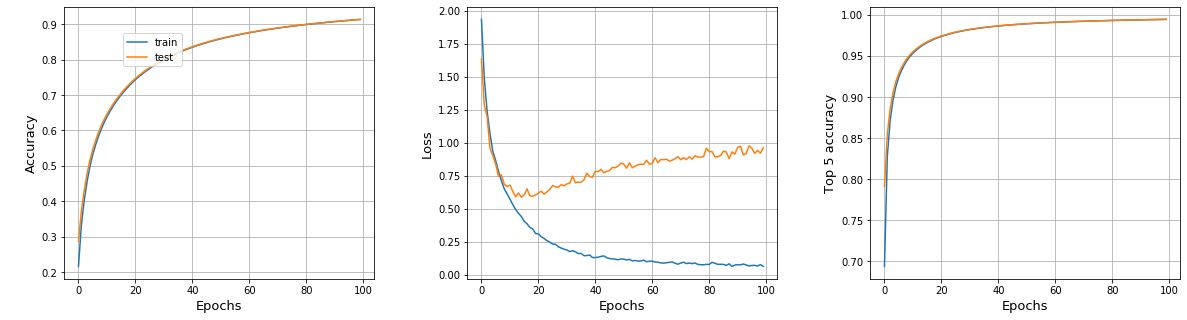

In [0]:
graph_(train_avg_acc_vgg3_bn, train_avg_loss_vgg3_bn, test_avg_acc_vgg3_bn, test_avg_loss_vgg3_bn , test_top5_vgg3_bn , train_top5_vgg3_bn)  

By using the whole dataset the model seems to start overfitting after 20 epochs.

This means for sure that our model needs less than 100 epochs to converge. However, it is not correct to decide in which epoch we should stop training using the test set's average loss per epoch since in this way the model may not generalize well. 

The optimal way is to find out a validation set ( different than the test set and the training set) which has the same distribution as the training set and use it to decide in which epoch our model should stop training (early stopping).


Below we create the validation set. 


In [0]:
valid_ys = shuffle(label_train.flatten(), random_state=1)
v_y=valid_ys[:10000]

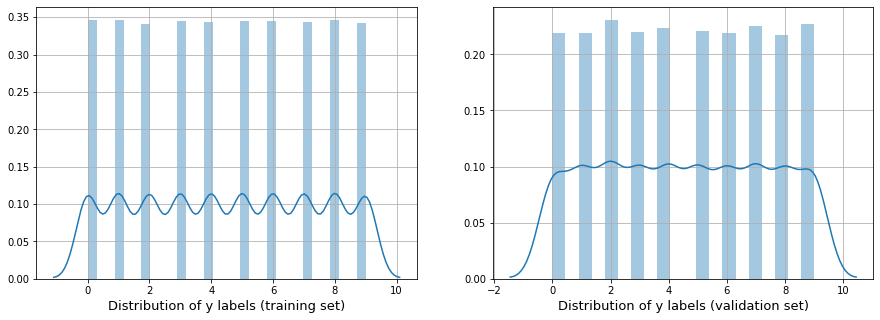

In [0]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust( wspace=0.2)
ax1 = fig.add_subplot(1, 2 ,1)
ax2 = fig.add_subplot(1, 2, 2)
# Figure 1
sns.distplot(label_train.flatten(), ax=ax1)
ax1.set_xlabel('Distribution of y labels (training set)',  fontsize=13)     

ax1.grid(True)
# Figure 2
sns.distplot(v_y, ax=ax2)
ax2.set_xlabel('Distribution of y labels (validation set)',  fontsize=13)     

ax2.grid(True)


As can be seen above after shuffling the training data and choosing the first 10.000 values we generate the validation set. The distribution of the validation set is quite close to the distribution of the training set.

In [0]:
data_train, label_train = shuffle(data_train, label_train, random_state=1)
data_valid= data_train[:10000]
label_valid=label_train[:10000]

In [0]:
data_train=data_train[10000:]
label_train=label_train[10000:]

In [0]:
def fit_4(optimiser, batch_size,
        batch_count, epochs, xdim=32 ,
        data_train=data_train, label_train=label_train, data_test=data_test, label_test=label_test, data_valid=data_valid , label_valid=label_valid):
    # reset the graph 
    graph1 = tf.Graph()
    with graph1.as_default():
      x = tf.placeholder(tf.float32, [None, xdim, xdim, 3], name='x')
      y = tf.placeholder(tf.int32, [None], name='y')
      training = tf.placeholder(tf.bool, shape=())
      outputs = classification_cnn_vgg_3_batch_normalization(x, training)

      top1, top1_op = tf.metrics.accuracy(y, tf.argmax(outputs, axis=1))
      top5, top5_op = tf.metrics.mean(tf.nn.in_top_k(predictions=outputs, targets=y, k=5))

      loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=outputs))
      
      with tf.control_dependencies(tf.compat.v1.get_collection(tf.GraphKeys.UPDATE_OPS) + [top1_op, top5_op]   ):                                                            
        optimiser_ = optimiser.minimize(loss) 

    with tf.Session(graph=graph1) as sess:

        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        train_avg_acc=[]
        train_top5=[]
        train_avg_loss=[] 
        valid_avg_acc=[]
        valid_avg_loss=[]
        valid_top5=[]
        test_avg_acc=[]
        test_avg_loss=[]
        test_top5=[]

        print ("Start")
        for e in range(epochs):
            avg_loss=0.
            avg_acc1=0. 
            avg_top_5=0.
            epoch_xs, epoch_ys = shuffle(data_train, label_train)
            for i in range(batch_count):
                # obtain the x, y data for the batch and optimize
                batch_xs = epoch_xs[i*batch_size:(i+1)*batch_size]
                batch_ys = epoch_ys[i*batch_size:(i+1)*batch_size]
                _, l, acc1, acc5 = sess.run([optimiser_, loss, top1, top5], feed_dict={x: batch_xs, y: batch_ys.flatten(), training: True})
                # update the avg_loss
                avg_loss += l 
                avg_acc1 += acc1 
                avg_top_5 += acc5         

            train_avg_acc.append( avg_acc1/batch_count)
            train_avg_loss.append(avg_loss/batch_count)
            train_top5.append(avg_top_5/batch_count)

            valid1,valid2,valid3 = sess.run([top1, top5, loss], feed_dict={x: data_valid, y: label_valid.flatten(), training: False})
            valid_avg_acc.append( valid1)
            valid_avg_loss.append(valid3)
            valid_top5.append(valid2)

            test1,test2,test3 = sess.run([top1, top5, loss], feed_dict={x: data_test, y: label_test.flatten(), training: False})
            test_avg_acc.append( test1)
            test_avg_loss.append(test3)
            test_top5.append(test2)

            print ("EPOCH = %.2f : top1_valid = %.2f loss_valid = %.2f top1_train = %.2f loss_train = %.2f" % (e, valid1, valid3, avg_acc1/batch_count, avg_loss/batch_count))

    return train_avg_acc, train_avg_loss, valid_avg_acc, valid_avg_loss , valid_top5 , train_top5 , test_avg_acc, test_avg_loss , test_top5

In [0]:
Adamoptimiser = tf.train.AdamOptimizer(learning_rate=0.001)
train_avg_acc, train_avg_loss, valid_avg_acc, valid_avg_loss , valid_top5 , train_top5 , test_avg_acc, test_avg_loss , test_top5 = fit_4(Adamoptimiser, 128, 312, 100 )

Start
EPOCH = 0.00 : top1_valid = 0.37 loss_valid = 1.32 top1_train = 0.27 loss_train = 1.68
EPOCH = 1.00 : top1_valid = 0.48 loss_valid = 0.96 top1_train = 0.43 loss_train = 1.16
EPOCH = 2.00 : top1_valid = 0.54 loss_valid = 0.80 top1_train = 0.51 loss_train = 0.90
EPOCH = 3.00 : top1_valid = 0.59 loss_valid = 0.72 top1_train = 0.57 loss_train = 0.75
EPOCH = 4.00 : top1_valid = 0.63 loss_valid = 0.68 top1_train = 0.61 loss_train = 0.63
EPOCH = 5.00 : top1_valid = 0.66 loss_valid = 0.69 top1_train = 0.65 loss_train = 0.54
EPOCH = 6.00 : top1_valid = 0.68 loss_valid = 0.64 top1_train = 0.67 loss_train = 0.48
EPOCH = 7.00 : top1_valid = 0.71 loss_valid = 0.68 top1_train = 0.70 loss_train = 0.42
EPOCH = 8.00 : top1_valid = 0.72 loss_valid = 0.67 top1_train = 0.71 loss_train = 0.37
EPOCH = 9.00 : top1_valid = 0.74 loss_valid = 0.69 top1_train = 0.73 loss_train = 0.33
EPOCH = 10.00 : top1_valid = 0.75 loss_valid = 0.70 top1_train = 0.75 loss_train = 0.30
EPOCH = 11.00 : top1_valid = 0.77 lo

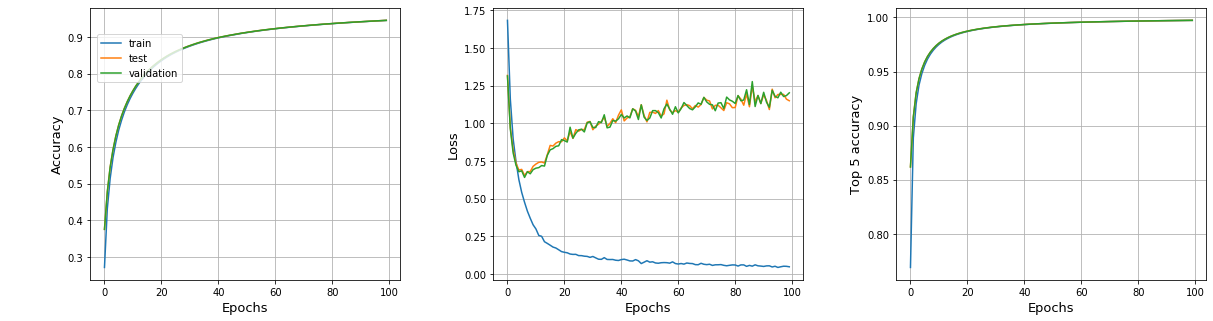

In [0]:
graph_2(train_avg_acc, train_avg_loss, valid_avg_acc, valid_avg_loss , valid_top5 , train_top5 , test_avg_acc, test_avg_loss , test_top5)

As we can see from the Loss diagram, the model starts overfitting after 10 epochs. So we will retrain our model using only 13 epochs much less than the simulation 3. This is what expected since in this case we use the whole dataset per epoch while in simulation 3 we used only 6400 samples per epoch. By using the whole dataset the model need less epochs to converge.

Below we retrain our model using only 13 epochs.

In [0]:
Adamoptimiser = tf.train.AdamOptimizer(learning_rate=0.001)
train_avg_acc_e10, train_avg_loss_e10, valid_avg_acc_e10, valid_avg_loss_e10 , valid_top5_e10 , train_top5_e10 , test_avg_acc_e10, test_avg_loss_e10 , test_top5_e10 = fit_4(Adamoptimiser, 128, 312, 13 )

Start
EPOCH = 0.00 : top1_valid = 0.38 loss_valid = 1.34 top1_train = 0.28 loss_train = 1.68
EPOCH = 1.00 : top1_valid = 0.49 loss_valid = 0.98 top1_train = 0.44 loss_train = 1.12
EPOCH = 2.00 : top1_valid = 0.56 loss_valid = 0.77 top1_train = 0.53 loss_train = 0.87
EPOCH = 3.00 : top1_valid = 0.60 loss_valid = 0.71 top1_train = 0.58 loss_train = 0.73
EPOCH = 4.00 : top1_valid = 0.64 loss_valid = 0.65 top1_train = 0.62 loss_train = 0.61
EPOCH = 5.00 : top1_valid = 0.67 loss_valid = 0.61 top1_train = 0.65 loss_train = 0.53
EPOCH = 6.00 : top1_valid = 0.69 loss_valid = 0.63 top1_train = 0.68 loss_train = 0.46
EPOCH = 7.00 : top1_valid = 0.71 loss_valid = 0.60 top1_train = 0.70 loss_train = 0.40
EPOCH = 8.00 : top1_valid = 0.73 loss_valid = 0.62 top1_train = 0.72 loss_train = 0.35
EPOCH = 9.00 : top1_valid = 0.75 loss_valid = 0.68 top1_train = 0.74 loss_train = 0.31
EPOCH = 10.00 : top1_valid = 0.76 loss_valid = 0.68 top1_train = 0.75 loss_train = 0.28
EPOCH = 11.00 : top1_valid = 0.77 lo

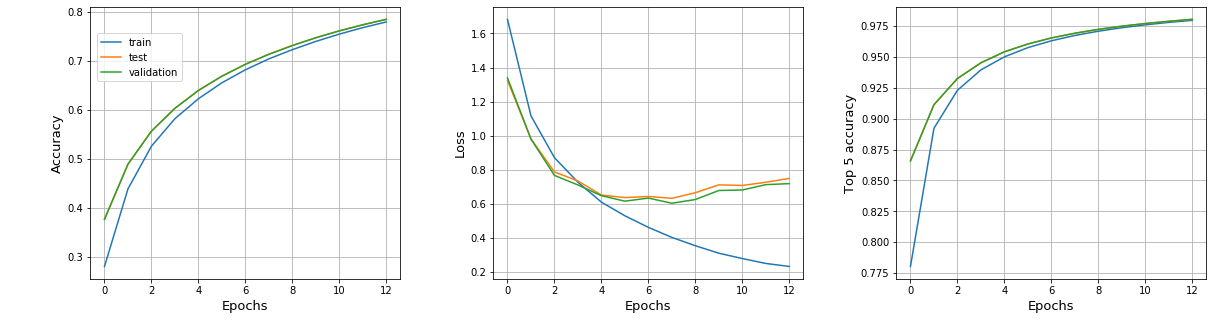

In [0]:
graph_2(train_avg_acc_e10, train_avg_loss_e10, valid_avg_acc_e10, valid_avg_loss_e10 , valid_top5_e10 , train_top5_e10 , test_avg_acc_e10, test_avg_loss_e10 , test_top5_e10)

In [0]:
print ("Accuracy of Training set : %.2f" % (train_avg_acc_e10[-1]*100), "%")
print ("Accuracy of Test set : %.2f " % (test_avg_acc_e10[-1]*100), "%")
print ("Top 5 Accuracy of Training set : %.2f"% (train_top5_e10[-1]*100), "%")
print ("Top 5 Accuracy of Test set : %.2f" % (test_top5_e10[-1]*100 ), "%")


Accuracy of Training set : 79.80 %
Accuracy of Test set : 80.23  %
Top 5 Accuracy of Training set : 98.22 %
Top 5 Accuracy of Test set : 98.28 %


As we can see the accuracy of this model is quite close to the accuracy of the model used in simulation 3. The same goes for top 5 accuracy rate. Both models are valid ( no overfitting ), so both of them can be used later for prediction purposes.  